
# 나를 찾아줘 - Class Activation Map 만들기


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDBKFPN/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDBKFPN/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


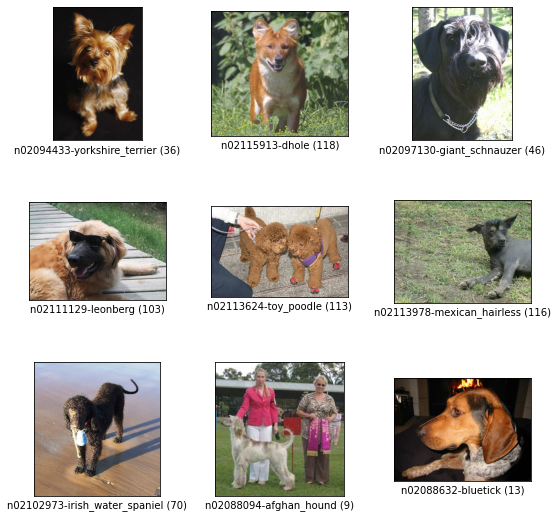

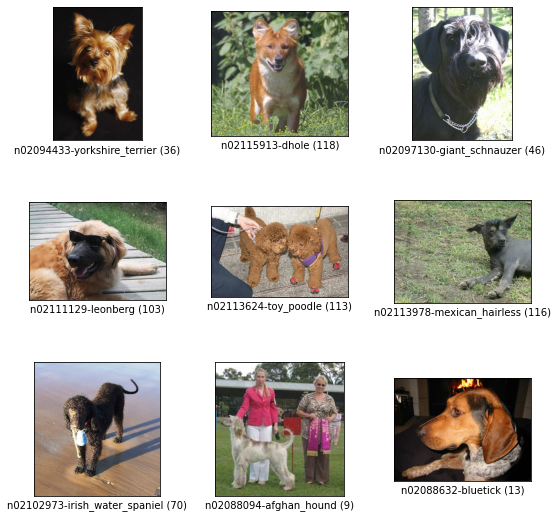

In [7]:
tfds.show_examples(ds_train, ds_info)

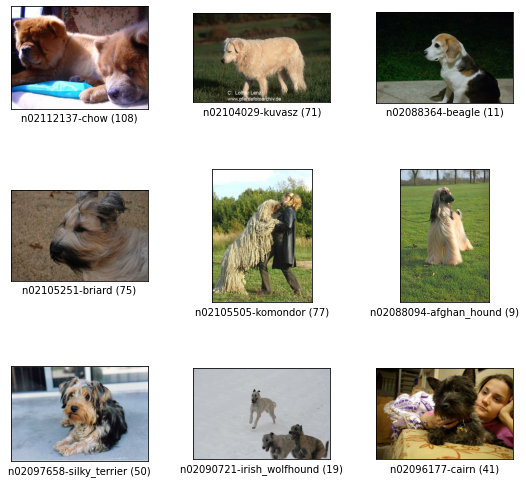

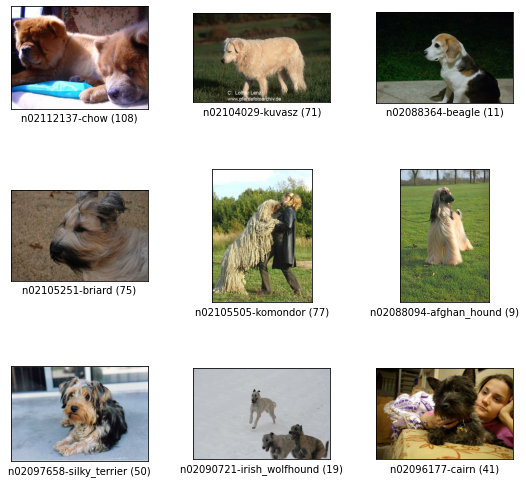

In [8]:
tfds.show_examples(ds_test, ds_info)

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

In [12]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [13]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [14]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [15]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 172s 205ms/step - loss: 2.1764 - accuracy: 0.4523 - val_loss: 3.4399 - val_accuracy: 0.1956
Epoch 2/10
750/750 [==============================] - 158s 210ms/step - loss: 0.6614 - accuracy: 0.8194 - val_loss: 1.0904 - val_accuracy: 0.6817
Epoch 3/10
750/750 [==============================] - 159s 212ms/step - loss: 0.1773 - accuracy: 0.9672 - val_loss: 0.9110 - val_accuracy: 0.7316
Epoch 4/10
750/750 [==============================] - 159s 211ms/step - loss: 0.0442 - accuracy: 0.9978 - val_loss: 0.8912 - val_accuracy: 0.7413
Epoch 5/10
750/750 [==============================] - 159s 212ms/step - loss: 0.0201 - accuracy: 0.9998 - val_loss: 0.9010 - val_accuracy: 0.7408
Epoch 6/10
750/750 [==============================] - 159s 212ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.9101 - val_accuracy: 0.7447
Epoch 7/10
750/750 [==============================] - 159s 212ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9270 -

In [16]:
import os

cam_model_path =  '/content/drive/MyDrive/AIFFEL/EXP/data/class_activation_map/cam_model2.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


In [17]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [18]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


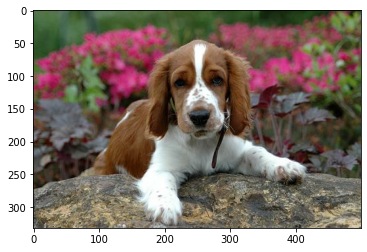

In [19]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [21]:
import os
cam_model_path = '/content/drive/MyDrive/AIFFEL/EXP/data/class_activation_map/cam_model2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [22]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

40


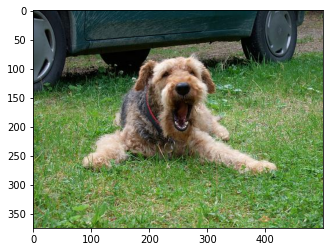

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [24]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


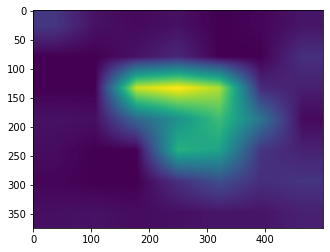

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

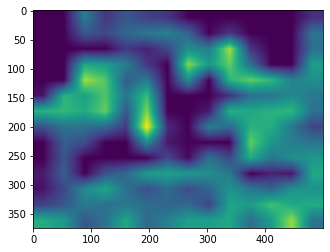

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

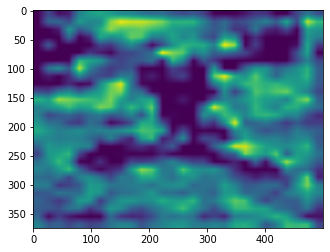

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### 바운딩 박스

108


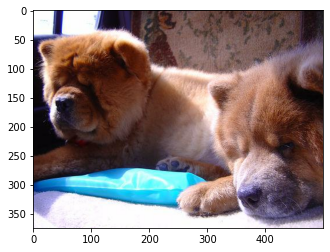

In [28]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

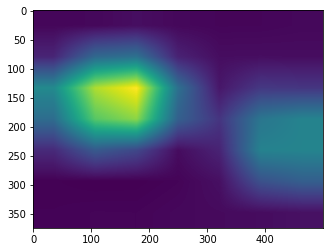

In [29]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [30]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [31]:
rect = get_bbox(cam_image)
rect

array([[-39, 261],
       [ 10,  -4],
       [545,  95],
       [495, 361]])

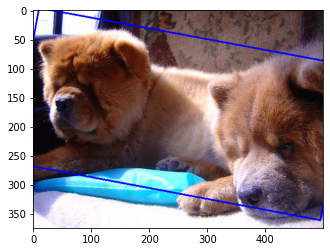

In [32]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union

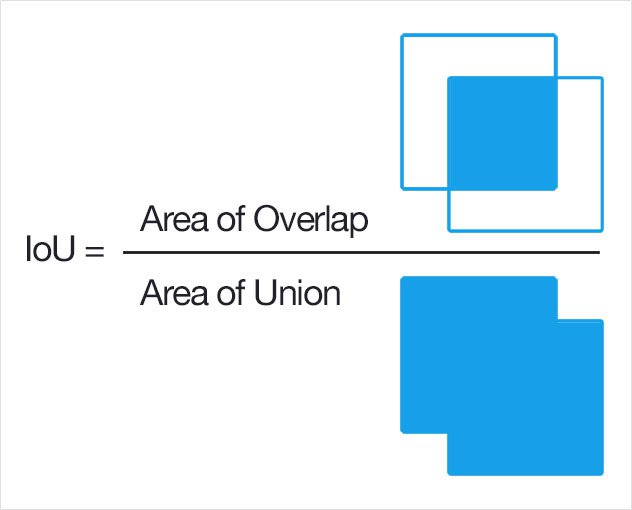

In [33]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [34]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.010666666666666666, -0.078, 0.9626666666666667, 1.09]

In [35]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [37]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.37279478190720267

# 프로젝트: CAM을 만들고 평가해 보자

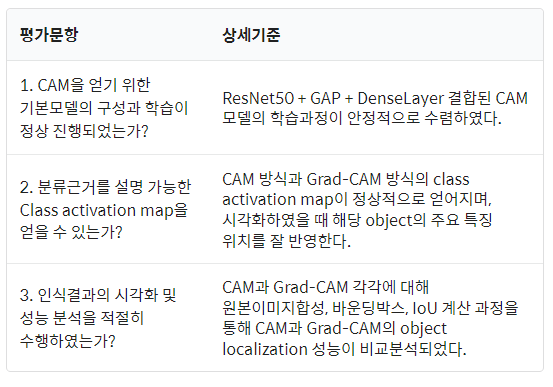

# CAM 구현하기

In [38]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import os

In [39]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
# import urllib3
# urllib3.disable_warnings()

# # 데이터셋 다운로드
# (ds_train, ds_test), ds_info = tfds.load(name='cars196',
#                                         split=['train', 'test'],
#                                         shuffle_files=True,
#                                         with_info=True,
#                                         )

In [41]:
import urllib3
urllib3.disable_warnings()

# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


In [42]:
# 데이터셋 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [43]:
# features가 어떻게 구성되어 있는지 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [44]:
# 데이터셋 features의 keys 정보 확인
sorted(ds_info.features.keys())

['image', 'image/filename', 'label', 'objects']

In [45]:
# 데이터 개수 확인
print('train :', ds_info.splits['train'])
print('test  :', ds_info.splits['test'])

train : <tfds.core.SplitInfo num_examples=12000>
test  : <tfds.core.SplitInfo num_examples=8580>


In [46]:
# 데이터 개수 확인 
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(12000, shape=(), dtype=int64)
test  : tf.Tensor(8580, shape=(), dtype=int64)


In [47]:
# 클래스의 개수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 120


In [48]:
# 클래스의 이름 확인
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

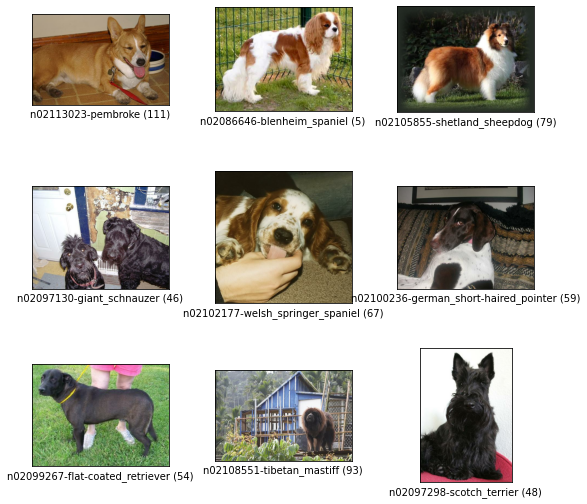

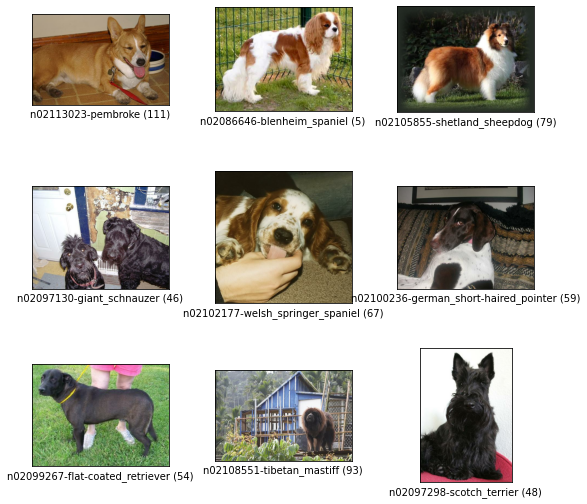

In [49]:
# 학습용 데이터셋 각 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_train, ds_info)

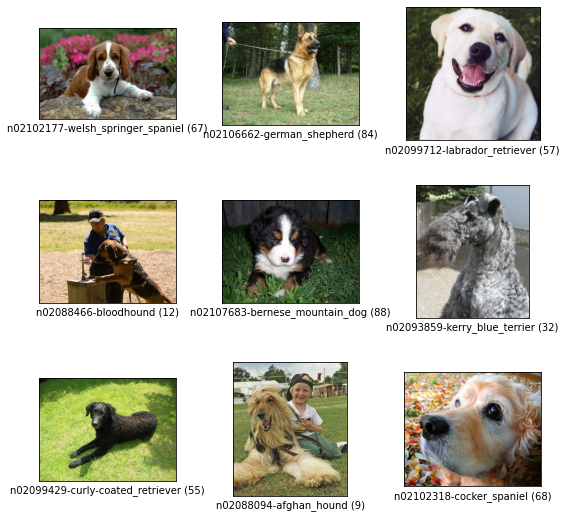

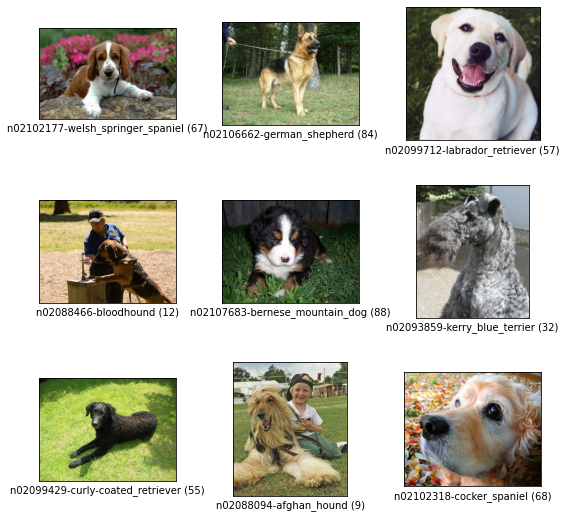

In [50]:
# 평가용 데이터셋 각 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_test, ds_info)

In [51]:
# 선행학습된 모델로부터 기준모델 만들기
base_model = keras.applications.resnet.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',        # Global Average Pooling 적용  
)

# 모든 모델의 학습가능 플레그를 False로 세팅하여 모든 레이어 고정
# base_model.trainable = False        # layer.trainable = False  # Freeze the layer

# 분류 헤드를 추가하기
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# 학습할 CAM모델 생성 및 확인
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

cam_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [52]:
tf.keras.utils.plot_model(cam_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [53]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

In [54]:
# 데이터 전처리 함수
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 데이터 배치처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [55]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)


# 구성된 배치의 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [56]:
import math

# 학습율 감소 함수
def lr_step_decay(epoch):
    init_lr = 0.01          # self.flag.initial_learning_rate
    lr_decay = 0.5           # self.flag.learning_rate_decay_factor
    epoch_per_decay = 5     # self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [57]:
from tensorflow.keras.callbacks import LearningRateScheduler

# learning schedule callback
learning_rate = LearningRateScheduler(lr_step_decay)
callbacks_list = [learning_rate]

In [58]:
from tensorflow.keras.optimizers import *

tf.random.set_seed(2021)

# 모델 학습과정 설정하기
cam_model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  )
# 모델 학습시키기
history_cam_model = cam_model.fit_generator(
    generator=ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=20,
    callbacks = callbacks_list,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


375/375 [==============================] - 84s 207ms/step - loss: 2.9664 - accuracy: 0.3038 - val_loss: 5.4070 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 2/20
375/375 [==============================] - 79s 210ms/step - loss: 1.4861 - accuracy: 0.5807 - val_loss: 3.1504 - val_accuracy: 0.2500 - lr: 0.0100
Epoch 3/20
375/375 [==============================] - 80s 213ms/step - loss: 0.8736 - accuracy: 0.7555 - val_loss: 1.2309 - val_accuracy: 0.6439 - lr: 0.0100
Epoch 4/20
375/375 [==============================] - 80s 214ms/step - loss: 0.5069 - accuracy: 0.8637 - val_loss: 1.1084 - val_accuracy: 0.6800 - lr: 0.0100
Epoch 5/20
375/375 [==============================] - 81s 215ms/step - loss: 0.2363 - accuracy: 0.9543 - val_loss: 0.8929 - val_accuracy: 0.7290 - lr: 0.0050
Epoch 6/20
375/375 [==============================] - 81s 215ms/step - loss: 0.1182 - accuracy: 0.9888 - val_loss: 0.9225 - val_accuracy: 0.7243 - lr: 0.0050
Epoch 7/20
375/375 [==============================] - 81s 215ms

In [67]:
# 학습시킨 모델 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model01.h5'
cam_model.save(cam_model_path)

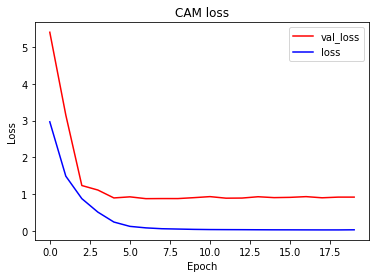

In [68]:
# 훈련 과정 loss 시각화
plt.plot(history_cam_model.history['val_loss'], 'r')
plt.plot(history_cam_model.history['loss'], 'b')
plt.title('CAM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

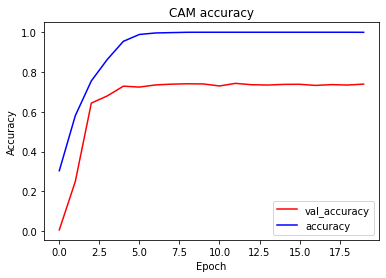

In [69]:
# 훈련 과정 accuracy 시각화
plt.plot(history_cam_model.history['val_accuracy'], 'r')
plt.plot(history_cam_model.history['accuracy'], 'b')
plt.title('CAM accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='lower right')
plt.show()

## 학습된 모델을 활용한 CAM 생성

In [133]:
# 데이터셋에서 한 장씩 가져오는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox'].flatten()
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


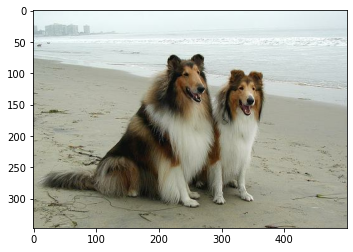

In [134]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [135]:
# 학습한 모델 불러오기
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model01.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [136]:
# 입력 이미지와 동일한 크기의 CAM을 반환하는 함수
def generate_cam(model, item):
    cam_image = None
    
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model(inputs=[model.inputs], 
                                      outputs=[model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 모델의 마지막 레이어에서 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    
    return cam_image

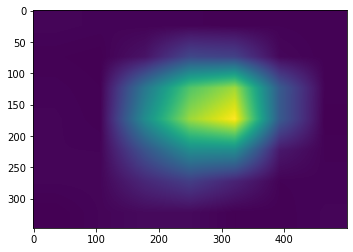

In [137]:
# generate_cam 함수 적용
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [138]:
# 원본과 CAM을 겹쳐 보여주는 함수
def visualize_cam_on_image(image, cam_image, alpha=0.2):
#     img1 = cv2.imread(image)
#     img2 = cv2.imread(cam_image)

#     # 블렌딩하는 두 이미지의 크기가 같아야함
#     width = img1.shape[1]
#     height = img1.shape[0]
#     img2 = cv2.resize(img2, (width, height))
    
    # image 사진은 점점 투명해지고 cam_image 사진은 점점 불투명해짐
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    
    return merged_image

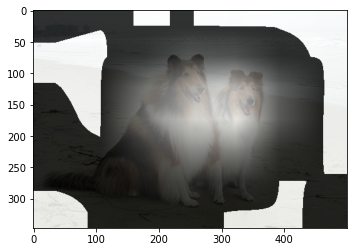

In [139]:
# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(origin_image, cam_image_3channel)
plt.imshow(blended_image)

In [140]:
blended_image.shape

(347, 500, 3)

# Grad-CAM 구현하기

In [141]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 정규화 및 크기 변경
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 모델의 input과 output 새롭게 정의
    grad_model = tf.keras.models.Model(inputs=[model.inputs], 
                                       outputs=[model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx]   # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0]     # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    # gradient의 GAP으로 class별 weight를 구합니다.
    weights = np.mean(grad_val, axis=(0, 1)) 
    
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)   # 정규화
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))   # 이미지 크기 복원

    return grad_cam_image

In [142]:
# 레이어의 이름 확인
cam_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

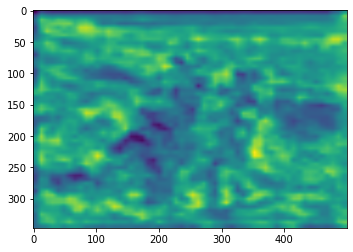

In [143]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)

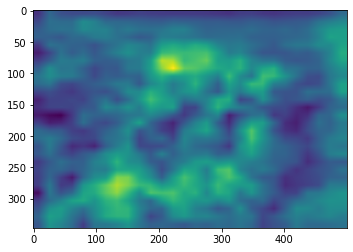

In [144]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block4_out', item)
plt.imshow(grad_cam_image)

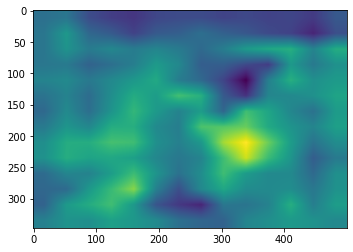

In [145]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)

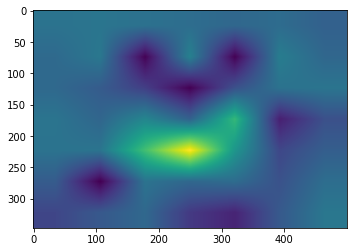

In [146]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

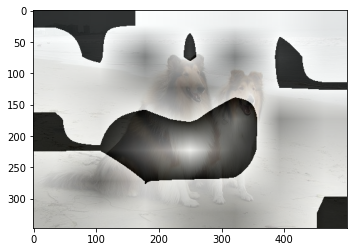

In [147]:
# visualize_cam_on_image() 함수 사용
grad_origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_origin_image, grad_cam_image_3channel)
plt.imshow(grad_blended_image)

In [164]:
print(grad_origin_image)

[[[230 244 245]
  [228 242 243]
  [226 240 241]
  ...
  [227 238 242]
  [227 238 242]
  [228 239 243]]

 [[230 244 245]
  [228 242 243]
  [226 240 241]
  ...
  [221 232 236]
  [222 233 237]
  [222 233 237]]

 [[230 244 245]
  [228 242 243]
  [226 240 241]
  ...
  [224 235 239]
  [224 235 239]
  [224 235 239]]

 ...

 [[164 166 144]
  [167 169 147]
  [163 165 143]
  ...
  [161 162 148]
  [161 162 148]
  [161 162 148]]

 [[165 167 145]
  [167 169 147]
  [162 164 142]
  ...
  [162 163 149]
  [162 163 149]
  [162 163 149]]

 [[166 168 146]
  [167 169 147]
  [161 163 141]
  ...
  [162 163 149]
  [162 163 149]
  [162 163 149]]]


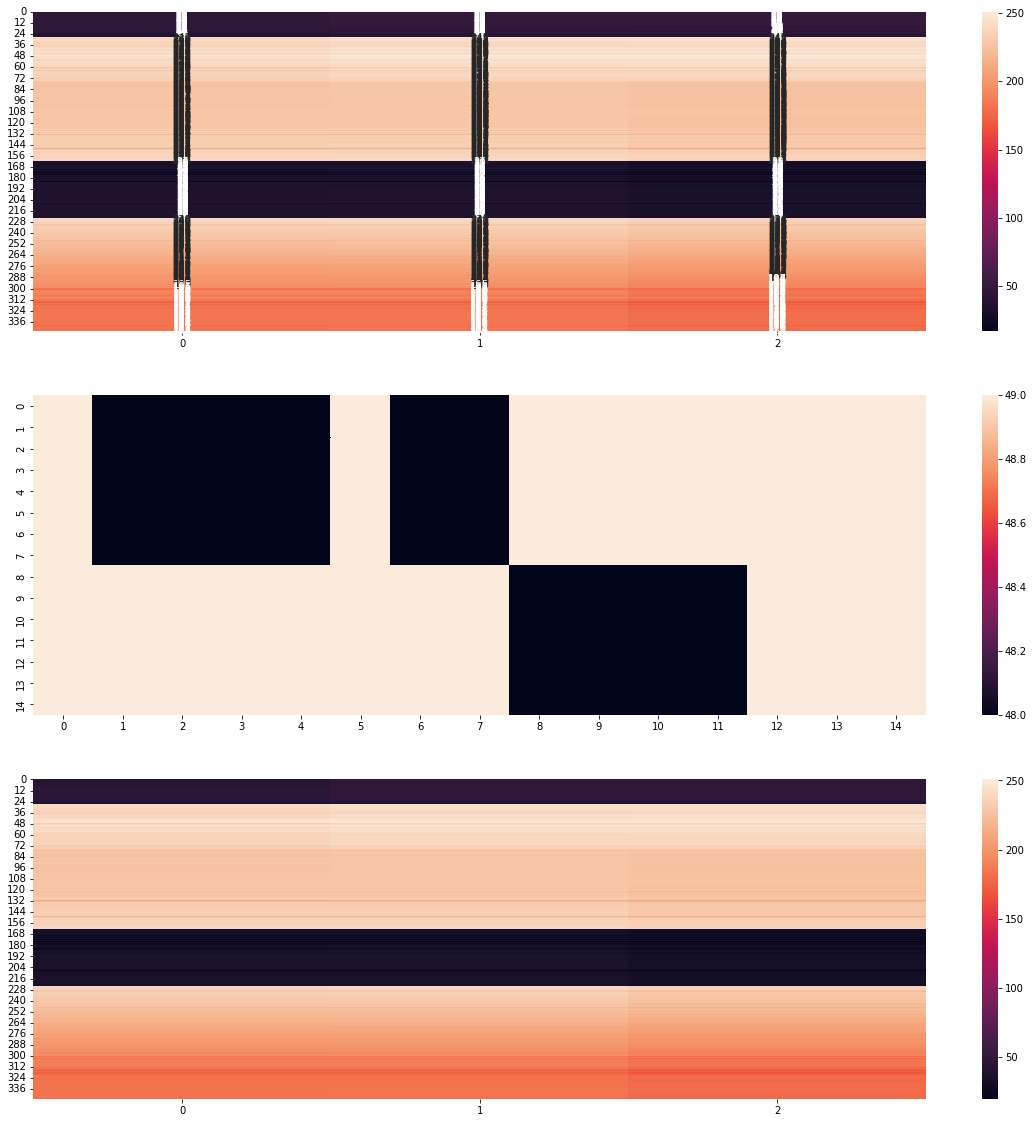

In [181]:
import matplotlib.pylab as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
plt.subplot(311)
sns.heatmap(grad_blended_image[:,0], annot=True, fmt="d")
# plt.imshow(grad_blended_image[:,0], cmap=plt.cm.bone)
# plt.axis("off")
# plt.title("R channel")

plt.subplot(312)
sns.heatmap(grad_blended_image[:15,:15,1])
# plt.imshow(grad_blended_image[:,1], cmap=plt.cm.bone)
# plt.axis("off")
# plt.title("G channel")

plt.subplot(313)
sns.heatmap(grad_blended_image[:,2])
# plt.imshow(grad_blended_image[:,2], cmap=plt.cm.bone)
# plt.axis("off")
# plt.title("G channel")

# plt.show()

In [148]:
def get_bbox(cam_image, score_thresh=0.05):
    # 임계값 이하의 바운딩 박스 제거
    low_indicies = cam_image <= score_thresh     
    cam_image[low_indicies] = 0
    
    # 정규화 복원
    cam_image = (cam_image*255).astype(np.uint8)
    
    # 사각형 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]     # 찾은 contour들 중에서 첫번째 contour
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    return rect

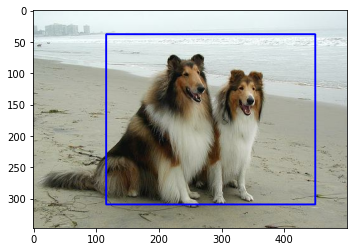

In [149]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)

In [150]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [151]:
# rect의 꼭지점 좌표
rect = get_bbox(cam_image)
rect

array([[116,  38],
       [449,  38],
       [449, 309],
       [116, 309]])

In [152]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.10951008645533142, 0.232, 0.8904899135446686, 0.898]

In [153]:
# 이 데이터의 ground truth bbox를 확인

# flattern, reshape(-1)
item_bbox = item['objects']['bbox'].flatten()
item_bbox

array([0.19596542, 0.02      , 0.9048991 , 0.578     , 0.26224783,
       0.584     , 0.89048994, 0.736     ], dtype=float32)

In [154]:
# IoU 계산하는 함수
def get_iou(gt_bbox, pred_bbox):
    iou = None
    
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min = max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    box_gtArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    box_predArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(box_gtArea + box_predArea - interArea)
    
    return iou

In [155]:
get_iou(pred_bbox, item_bbox)

0.35579089282121895

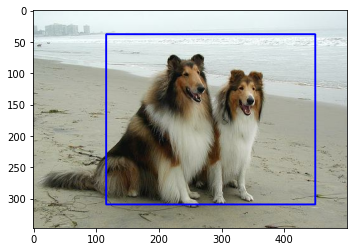

In [156]:
# CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_cam = get_bbox(cam_image)

image_cam = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)

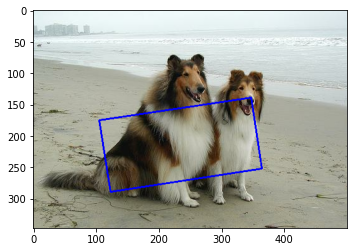

In [157]:
# Grad-CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_grad_cam = get_bbox(grad_cam_image)

image_grad_cam = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image_grad_cam)

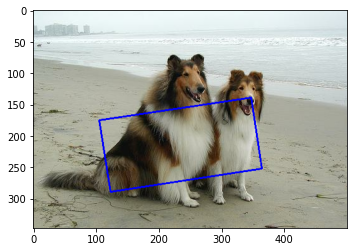

In [158]:
# Grad-CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_grad_cam = get_bbox(grad_cam_image)

image_grad_cam = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image_grad_cam)

In [159]:
# 이미지 크기
image.shape[0], image.shape[1]

(347, 500)

In [160]:
# 정답 바운딩 박스 꼭지점 좌표
box_gt = item_bbox     # 정규화된 좌표

y1 = int(box_gt[0]*image.shape[0])   # 복원된 좌표
x1 = int(box_gt[1]*image.shape[1])

y2 = int(box_gt[2]*image.shape[0])
x2 = int(box_gt[3]*image.shape[1])

box_gt = (x1, y1), (x2, y2)
box_gt

((9, 68), (289, 313))

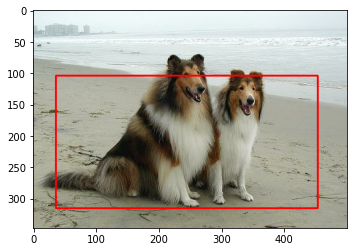

In [161]:
# 정답 바운딩 박스
image = copy.deepcopy(item['image'])
image_gt_box = cv2.rectangle(image, (36, 104), (453, 315), (255,0,0), 2)
plt.imshow(image_gt_box)

In [162]:
# CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
get_iou(pred_bbox_cam, item_bbox)

0.35579089282121895

In [163]:
# Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
get_iou(pred_bbox_grad_cam, item_bbox)

0.345500975923308

회고

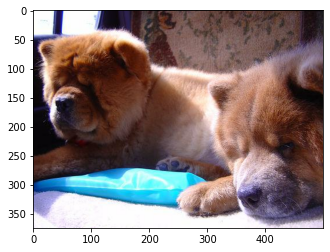

cam : 0.4632308854163996, Grad-CAM : 0.0005635497653107923

40번 이미지

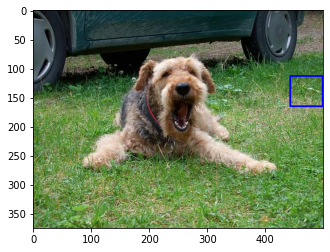

CAM : 0.49813602254190387, Grad-CAM : 0

파란색 네모 박스가 Grad-CAM으로 그려진 BBox --> Ground-Truth와 완전히 떨어져 있었음.

40번 이미지

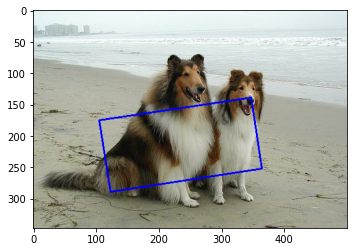
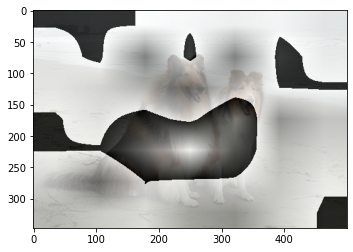

첫번째 그림은 Grad-CAM에 의한 BBox이며 CAM의 BBox와 매우 유사

grad_blended_image에서 뿌연 부분은 의미가 없는 데이터인 것 같다. 

0.35579089282121895, 0.345500975923308와 같이 유사한 IoU 값을 갖는 것을 알 수 있다.